# **IMPORTADO DE MÓDULOS/FUNCTIONS**

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.optimizers import Adam

2024-05-31 16:50:32.210398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 16:50:32.234745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 16:50:32.627398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
source = 'Co60'
path = '/home/josea/PracticaTimingDigital/pulso_' + source + '_filt_norm.npz'

data = np.load(path)
pulsos_practica_master = data['data']

In [4]:
from functions import gauss, gauss_fit, create_and_delay_pulse_pair, move_to_reference, get_mean_pulse_from_set, pulso_escalon, create_position
from Models import model_definition_convolutional

# **INTERPOLACION**

In [5]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28,  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55,  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82,  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)

interp_func_practica = interp1d(tiempo, pulsos_practica_master,  kind='cubic', axis=1)
new_pulsos_practica = interp_func_practica(tiempo_new)

#---------------------------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_pulsos_practica[:,:,1] = np.roll(new_pulsos_practica[:,:,1], align_steps)
new_pulsos_practica[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)


#----------------------------------------------------- Print important information -----------------------------------
print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [6]:
#------------------------------------- Define number of training examples --------------------------------
Ntrain_practicas = int(0.8*new_pulsos_practica.shape[0])
Ncasos_sim = 1
Nc = 2

#------------------------------------- Basic definitions for sim pulses -----------------------------
t = np.linspace(0, Nt, Nt_new)
t0 = 78 + np.random.randint(5, size = Ncasos_sim) 
#t0 = 600 + np.random.randint(100, size = Ncasos_sim) 

# **TRAINING IN COINCIDENCE**

In [7]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 3
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.3

#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 3
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.3

In [8]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Ncasos_sim,Nt_new))
INPUT_dec1 = np.zeros((Ncasos_sim,Nt_new))

for i in range(Ncasos_sim):
  
  centro = t0[i]
  #PULSO = pulso(t, centro, tau_rise = tau_rise_dec0)
  #PULSO = pulso(t, centro, tau_rise = tau_rise_dec1)
  PULSO = pulso_escalon(t, centro, A=0.7)
  PULSO = pulso_escalon(t, centro, A= 0.7)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
  INPUT_dec0[i,:] = PULSO
  INPUT_dec1[i,:] = PULSO


#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0, new_time_step, delay_steps = 32, NOISE = True)

In [10]:
#------------------------------------- Define cropping limits ------------------------------
t_shift = 8
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

#------------------------------------- Create  Train-Validation set  --------------------------------
train_data = new_pulsos_practica[:Ntrain_practicas]
validation_data = new_pulsos_practica[Ntrain_practicas:]

Train_data_02 = create_position(train_data, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
Train_data_20 = create_position(train_data, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)

validation_data_02 = create_position(validation_data, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
validation_data_20 = create_position(validation_data, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)


#------------------------------------- Reference time difference --------------------------------
REF = np.zeros(3*train_data.shape[0])
REF[:train_data.shape[0]] = 0.0
REF[train_data.shape[0]:2*train_data.shape[0]] = -t_shift*new_time_step
REF[2*train_data.shape[0]:3*train_data.shape[0]] = t_shift*new_time_step
REF_train = np.concatenate((REF_dec0, REF), axis = 0)



#------------------------------------- Concatenate training/validation sets --------------------------------
trainX = np.concatenate((INPUT_dec0[:,start:stop,:], train_data[:,start:stop,:], Train_data_02[:,start:stop,:], Train_data_20[:,start:stop,:]), axis = 0). swapaxes(1,2) #Swap the axis so they are the right shape for the NN
validationX = np.concatenate((validation_data[:,start:stop,:], validation_data_02[:,start:stop,:], validation_data_20[:,start:stop,:]), axis = 0). swapaxes(1,2) #Swap the axis so they are the right shape for the NN

In [15]:
#------------------------------------- Define neural network model --------------------------------
model = model_definition_convolutional(int(stop-start))

#opt = tf.keras.optimizers.AdamW(learning_rate=1e-4)
model.compile(optimizer='AdamW',loss='MSE')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 2, 240, 16)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 120, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 120, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 60, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         7,684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,849 (38.47 KB)

 Trainable params: 9,849 (38.47 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(trainX, REF_train, epochs = 100, batch_size = 512)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0261
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0208 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0067 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0060 
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step

CENTROID(ns) = -0.198  FWHM(ns) = 0.042  std(ns) = 0.018
CENTROID(ns) = 0.001  FWHM(ns) = 0.142  std(ns) = 0.060
CENTROID(ns) = 0.192  FWHM(ns) = 0.034  std(ns) = 0.014


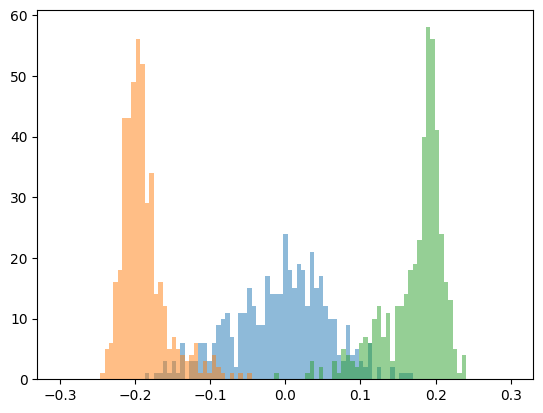

In [17]:
#------------------------------------------- Make prediction ----------------------------------------------
TOF = model.predict(validationX[:validation_data.shape[0],:,:])
TOF_02 = model.predict(validationX[validation_data.shape[0]:int(2*validation_data.shape[0]),:,:])
TOF_20 = model.predict(validationX[2*validation_data.shape[0]:3*validation_data.shape[0],:,:])

#------------------------------------------- Histogram and gaussian fit -----------------------------------
nbins = 101
histogN_V82, binsN, patchesN  = plt.hist(TOF, bins = nbins, range=[-0.3,0.3], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN_V82)

histogN_V82, binsN, patchesN  = plt.hist(TOF_02, bins = nbins, range=[-0.3,0.3], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_02, sigmaN_02 = gauss_fit(cbinsN, histogN_V82)

histogN_V82, binsN, patchesN  = plt.hist(TOF_20, bins = nbins, range=[-0.3,0.3], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_20, sigmaN_20 = gauss_fit(cbinsN, histogN_V82)

FWHMN = 2.35482 * sigmaN
FWHMN_02 = 2.35482 * sigmaN_02
FWHMN_20 = 2.35482 * sigmaN_20


print('')
print("CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_02, FWHMN_02, sigmaN_02))
print("CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N, FWHMN, sigmaN))
print("CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_20, FWHMN_20, sigmaN_20))

# **SINGLES TRAINING**

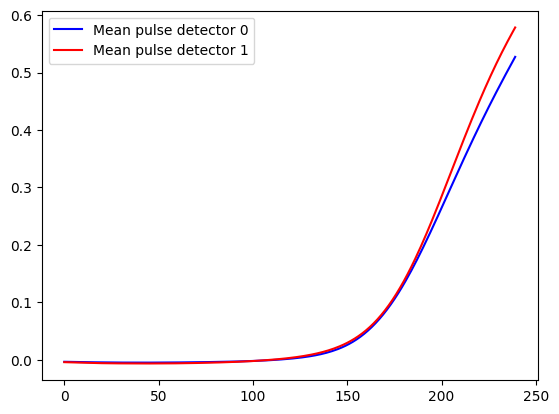

In [18]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_pulsos_practica, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_pulsos_practica, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

In [19]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Ncasos_sim,Nt_new))
INPUT_dec1 = np.zeros((Ncasos_sim,Nt_new))

for i in range(Ncasos_sim):
  
  centro = t0[i]
  #PULSO = pulso(t, centro,  tau_rise = tau_rise_dec0)
  #PULSO = pulso(t, centro, tau_rise = tau_rise_dec1)
  PULSO = pulso_escalon(t, centro, A=0.7)
  PULSO = pulso_escalon(t, centro, A= 0.7)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
  INPUT_dec0[i,:] = PULSO
  INPUT_dec1[i,:] = PULSO


#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0, new_time_step, delay_steps = 32, NOISE = True)
INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1, new_time_step, delay_steps = 32, NOISE = True)


In [20]:
#---------------------------------------------- Move to reference pulse --------------------------------
#delays_train_dec0 , moved_pulses_dec0 = move_to_reference(mean_pulse_dec0, new_pulsos_practica[:Ntrain_practicas,:,:], start = start, stop = stop, max_delay = 240, channel = 0)
#delays_train_dec1 , moved_pulses_dec1 = move_to_reference(mean_pulse_dec1, new_pulsos_practica[:Ntrain_practicas,:,:], start = start, stop = stop, max_delay = 240, channel = 1)


#---------------------------------------------- Delay real pulses --------------------------------
trainX_real_dec0, REF_real_train_dec0 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practicas,:,0], new_time_step, delay_steps = 32, NOISE = True)
trainX_real_dec1, REF_real_train_dec1 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practicas,:,1], new_time_step, delay_steps = 32, NOISE = True)
#trainX_real_dec0, REF_real_train_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, delay_steps = 20, NOISE = True)
#trainX_real_dec1, REF_real_train_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, delay_steps = 20, NOISE = True)

In [21]:
#---------------------------------------------- Create training set --------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0, trainX_real_dec0), axis = 0)
trainX_dec1 = np.concatenate((INPUT_dec1, trainX_real_dec1), axis = 0)

REF_train_dec0 = np.concatenate((REF_dec0, REF_real_train_dec0), axis = 0)
REF_train_dec1 = np.concatenate((REF_dec1, REF_real_train_dec1), axis = 0)

In [22]:
#-------------------------------- Swap axis to be compatible with the NN -------------------------------
trainX_dec0 = trainX_dec0[:,start:stop,:].swapaxes(1,2)
trainX_dec1 = trainX_dec1[:,start:stop,:].swapaxes(1,2)

## **FULL TOF**

In [23]:
#------------------------------------- Create reference pulses --------------------------------
REFERENCE_PULSE_dec0 = np.tile(mean_pulse_dec0[start:stop], (new_pulsos_practica[Ntrain_practicas:,:,:].shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_pulse_dec1[start:stop], (new_pulsos_practica[Ntrain_practicas:,:,:].shape[0],2,1)).swapaxes(1,2)


#--------------------------------------- Move pulses to a reference one -------------------------------------------------
#delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, new_pulsos_practica[Ntrain_practicas:,:,:], start = start, stop = stop, max_delay = 240, channel = 0)
#delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, new_pulsos_practica[Ntrain_practicas:,:,:], start = start, stop = stop, max_delay = 240, channel = 1)


#validation_data = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
validation_data = new_pulsos_practica[Ntrain_practicas:,start:stop,:]

validation_data_02 = create_position(validation_data, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
validation_data_20 = create_position(validation_data, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)  

#--------------------------------------- Create test set -------------------------------------------------
test_dec0_00 = np.stack((validation_data[:,:,0], REFERENCE_PULSE_dec0[:,:,0]), axis = 2).swapaxes(1,2)
test_dec1_00 = np.stack((validation_data[:,:,1], REFERENCE_PULSE_dec1[:,:,0]), axis = 2).swapaxes(1,2)
test_dec0_02 = np.stack((validation_data_02[:,:,0], REFERENCE_PULSE_dec0[:,:,0]), axis = 2).swapaxes(1,2)
test_dec1_02 = np.stack((validation_data_02[:,:,1], REFERENCE_PULSE_dec1[:,:,0]), axis = 2).swapaxes(1,2)
test_dec0_20 = np.stack((validation_data_20[:,:,0], REFERENCE_PULSE_dec0[:,:,0]), axis = 2).swapaxes(1,2)
test_dec1_20 = np.stack((validation_data_20[:,:,1], REFERENCE_PULSE_dec1[:,:,0]), axis = 2).swapaxes(1,2)

In [ ]:
epochs = 500
num_semillas = 1

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_00_list = []
TOFN_02_list = []
TOFN_20_list = []

for i in range(num_semillas):
  
  model_dec0 = model_definition_convolutional(int(stop-start))
  model_dec1 = model_definition_convolutional(int(stop-start))

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 5e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 5e-4)

  model_dec0.compile(optimizer = opt_dec0,loss = 'MSE')
  model_dec1.compile(optimizer = opt_dec1,loss = 'MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_00_epoch = []
  TOFN_02_epoch = []
  TOFN_20_epoch = []

  for epoch in range(epochs):
     
     history_dec0 = model_dec0.fit(trainX_dec0, REF_train_dec0, epochs = 4, batch_size = 64, verbose = 0)
     history_dec1 = model_dec1.fit(trainX_dec1, REF_train_dec1, epochs = 4, batch_size = 64, verbose = 0)
     
     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])

     
     TOFN_dec0_REF_00 = model_dec0.predict(test_dec0_00)
     TOFN_dec1_REF_00 = model_dec1.predict(test_dec1_00)
     TOFN_dec0_REF_02 = model_dec0.predict(test_dec0_02)
     TOFN_dec1_REF_02 = model_dec1.predict(test_dec1_02)
     TOFN_dec0_REF_20 = model_dec0.predict(test_dec0_20)
     TOFN_dec1_REF_20 = model_dec1.predict(test_dec1_20)

     
     #TOFN_00 = (np.squeeze(TOFN_dec0_REF_00) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_00) - new_time_step*delays_test_dec1)
     #TOFN_02 = (np.squeeze(TOFN_dec0_REF_02) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_02) - new_time_step*delays_test_dec1)
     #TOFN_20 = (np.squeeze(TOFN_dec0_REF_20) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_20) - new_time_step*delays_test_dec1)
     
     
     TOFN_00 = TOFN_dec0_REF_00 - TOFN_dec1_REF_00
     TOFN_02 = TOFN_dec0_REF_02 - TOFN_dec1_REF_02
     TOFN_20 = TOFN_dec0_REF_20 - TOFN_dec1_REF_20
     
     
     TOFN_00_epoch.append(TOFN_00)
     TOFN_02_epoch.append(TOFN_02)
     TOFN_20_epoch.append(TOFN_20)
 
     centroid_02 = np.mean(TOFN_02) - np.mean(TOFN_00)
     centroid_20 = np.mean(TOFN_20) - np.mean(TOFN_00)
     mean_error_centroid = (abs(centroid_02 + 0.2) + abs(centroid_20 - 0.2)) / 2 
     mean_std = (np.std(TOFN_00) +  np.std(TOFN_02) + np.std(TOFN_20)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_00_list.append(TOFN_00_epoch)
  TOFN_02_list.append(TOFN_02_epoch)
  TOFN_20_list.append(TOFN_20_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype = 'object')
std = np.array(std, dtype = 'object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_00_array = np.array(TOFN_00_list, dtype = 'object')
TOFN_02_array = np.array(TOFN_02_list, dtype = 'object')
TOFN_20_array = np.array(TOFN_20_list, dtype = 'object')

(array([0]), array([448])) 0.0754880760038625


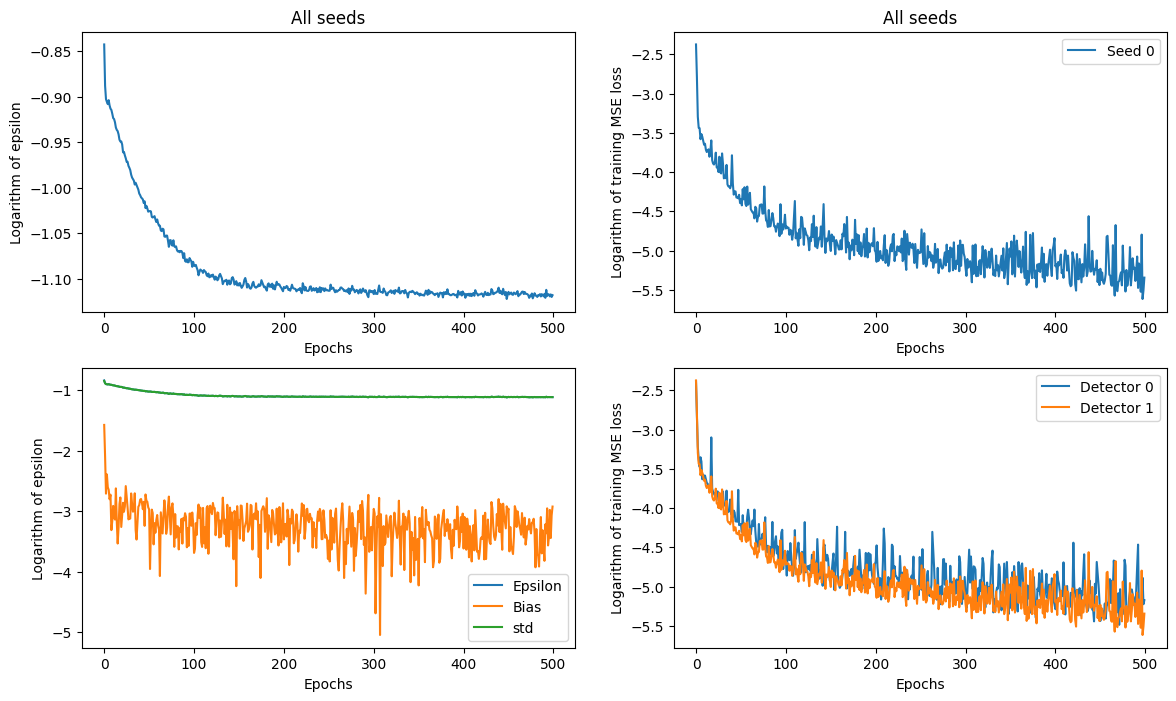

: 

In [34]:
epsilon = np.array(epsilon, dtype = 'float64')
bias = np.array(bias, dtype = 'float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 0
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  #plt.plot(np.log10(std[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]), label = label)
  plt.plot(np.log10(training_loss_dec1[i,:]), label = label)
plt.legend()
plt.ylabel('Logarithm of training MSE loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]), label = 'Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]), label = 'Detector 1')
plt.ylabel('Logarithm of training MSE loss')
plt.xlabel('Epochs')

plt.legend()


02: CENTROID(ns) = -0.192  FWHM(ns) = 0.186  std(ns) = 0.079
00: CENTROID(ns) = 0.006  FWHM(ns) = 0.183  std(ns) = 0.078
20: CENTROID(ns) = 0.205  FWHM(ns) = 0.182  std(ns) = 0.077


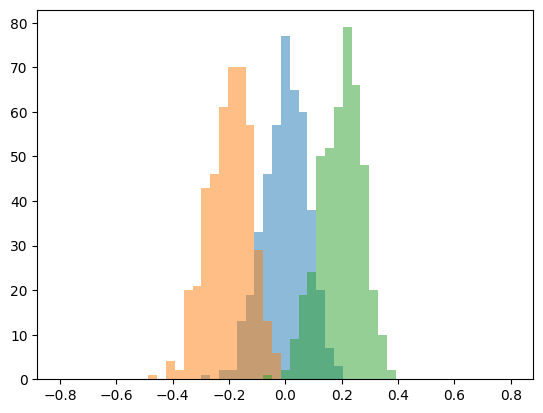

In [26]:
epoch = 448
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_00_array[index,epoch,:] - np.mean(TOFN_00_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_00, sigmaN_00 = gauss_fit(cbinsN, histogN_V82)

histogN_V82, binsN, patchesN  = plt.hist(TOFN_02_array[index,epoch,:] - np.mean(TOFN_00_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_02, sigmaN_02 = gauss_fit(cbinsN, histogN_V82)

histogN_V82, binsN, patchesN  = plt.hist(TOFN_20_array[index,epoch,:] - np.mean(TOFN_00_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_20, sigmaN_20 = gauss_fit(cbinsN, histogN_V82)

FWHMN_00 = 2.35482 * sigmaN_00
FWHMN_02 = 2.35482 * sigmaN_02
FWHMN_20 = 2.35482 * sigmaN_20



print('')
print("02: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_02, FWHMN_02, sigmaN_02))
print("00: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_00, FWHMN_00, sigmaN_00))
print("20: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_20, FWHMN_20, sigmaN_20))

# **ENSEMBLE MODEL**

In [ ]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_00 = np.average(np.squeeze(TOFN_00_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)
weighted_mean_02 = np.average(np.squeeze(TOFN_02_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)
weighted_mean_20 = np.average(np.squeeze(TOFN_20_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)

In [28]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(weighted_mean_20 - np.mean(weighted_mean_00), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(weighted_mean_00 - np.mean(weighted_mean_00), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(weighted_mean_02 - np.mean(weighted_mean_00), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28

print('')
print('Weighted mean:')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

NameError: name 'weighted_mean_20' is not defined